# Simulating flow

To use `bluebonnet.flow` in a project:

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d,UnivariateSpline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz


#import sys
#sys.path.insert(0,"/Users/michaelmarder/UTOneDrive/OneDrive - The University of Texas at Austin/Shale/bluebonnet/src/")

from bluebonnet.flow import (
    IdealReservoir, FlowProperties, FlowPropertiesMarder, FlowPropertiesTwoPhase, 
    SinglePhaseReservoir, SinglePhaseReservoirMarder,RelPermParams, relative_permeabilities
)
from bluebonnet.fluids.fluid import Fluid, pseudopressure
from bluebonnet import plotting

#plt.style.use("ggplot")

In [2]:
from platform import python_version
python_version()

'3.9.7'

In [2]:
def plot_pseudopressure(reservoir, rescale=False,ax=None,xmax=1,mbot=0,mtop=1.05):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.linspace(1/reservoir.nx, 1, reservoir.nx)
    pinit=reservoir.pseudopressure[0,-1]
    for i, p in enumerate(reservoir.pseudopressure):
        if i % 200 == 0:
            if rescale:
                pscale=(p-p[0])/(pinit-p[0])
                ax.plot(x,pscale, color='steelblue')
            else:
                ax.plot(x,p, color='steelblue')
    ax.set(xlabel="x", ylabel="Pseudopressure", xlim=(0, xmax), ylim=(mbot,mtop))
    return fig, ax

def plot_recovery_rate(reservoir, ax=None, change_ticks=False):
    if ax is None:
        fig, ax = plt.subplots()
    rf = reservoir.recovery_factor()
    rate=reservoir.rate
    time = reservoir.time
    ax.plot(time, rate)
    ax.set(xscale='log', yscale='log',ylim=(1.e-4, None), xlim=(0, max(time)))
    if change_ticks:
        tick_locs = np.round((np.linspace(0,1,7) * np.sqrt(max(time)))**2,1)
        ax.set_xticks(tick_locs)
    return ax

def plot_recovery_factor(reservoir, ax=None, change_ticks=False):
    if ax is None:
        fig, ax = plt.subplots()
    rf = reservoir.recovery_factor()
    time = reservoir.time
    ax.plot(time, rf)
    ax.set(xscale='squareroot', ylim=(0, None), xlim=(0, max(time)))
    if change_ticks:
        tick_locs = np.round((np.linspace(0,1,7) * np.sqrt(max(time)))**2,1)
        ax.set_xticks(tick_locs)
    return ax


In [3]:
t_end = 10
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2


## Ideal gas simulation

CPU times: user 990 ms, sys: 19.4 ms, total: 1.01 s
Wall time: 1.03 s
0.04202458275067625
0.04166666666666663


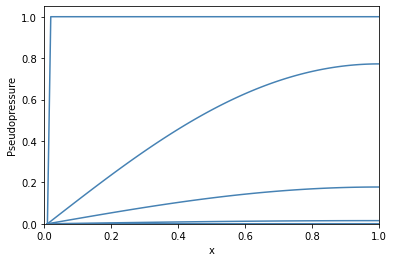

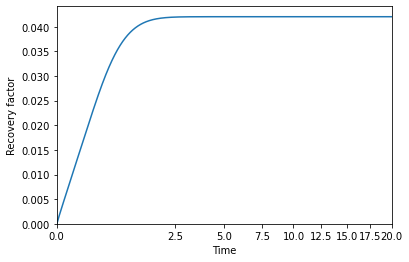

In [71]:
Pi=12000
Pf=11500
res_ideal = IdealReservoir(100, Pf, Pi, None)
%time res_ideal.simulate(time)
rf_ideal = res_ideal.recovery_factor()
ax = plot_pseudopressure(res_ideal)

ax = plot_recovery_factor(res_ideal)
ax.set(xlabel="Time", ylabel="Recovery factor")
print(rf_ideal[-1])
print(1-Pf/Pi)

## Real gas simulation

In [82]:
Pi=12000
Pf=1000
Pf=1500


t_end = 20
time = np.linspace(0, np.sqrt(t_end), 500) ** 2

pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")

ms=2*cumtrapz(pvt_gas.P/(pvt_gas.Viscosity*pvt_gas["Z-Factor"]),pvt_gas.P)
ms=np.concatenate(([0],ms))
pvt_gas.pseudopressure=ms
#pvt_gas.Cg=1./pvt_gas.P-1/pvt_gas["Z-Factor"]*Zfunc.derivative()(pvt_gas.P)


flow_propertiesM = FlowPropertiesMarder(pvt_gas, Pi)

print('mf=',flow_propertiesM.m_scaled_func(Pf))

res_realgasM = SinglePhaseReservoirMarder(50, Pf, Pi, flow_propertiesM)

%time res_realgasM.simulate(time)

rf2M = res_realgasM.recovery_factor()
rf2M[-1]


mf= 0.010157269900418514
Most current version.
0.3631517889980861 0.010157269900418514
CPU times: user 914 ms, sys: 12.1 ms, total: 926 ms
Wall time: 920 ms


0.7997686839374252

0.010157269900418514 0.01016126036432835
0.3631517889980861


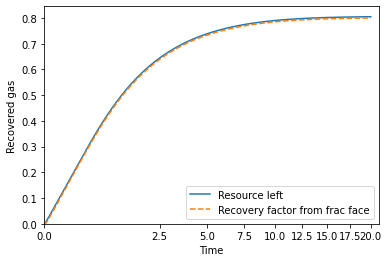

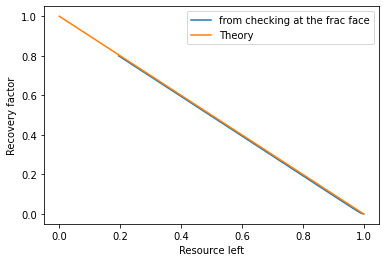

In [83]:
from scipy import interpolate
density_interp = interpolate.interp1d(flow_propertiesM.df["m_scaled"], flow_propertiesM.df["Density"])

def resource_left(pseudopressure, pvt):
    density = interpolate.interp1d(pvt.df["m_scaled"], pvt.df["Density"])
    print(max(pvt.df["m_scaled"]))
    p=np.minimum(pseudopressure,max(pvt.df["m_scaled"]))
    return (density(p)).sum(axis=1)/len(pseudopressure[0])
mf=flow_propertiesM.m_scaled_func(Pf)
mi=flow_propertiesM.m_scaled_func(Pi)
print(mf,res_realgasM.pseudopressure[-1][0])

remaining_gasM = (resource_left(res_realgasM.pseudopressure, flow_propertiesM) )/(density_interp(mi))
fig, ax = plt.subplots()
ax.plot(time, 1 - remaining_gasM, label="Resource left")
ax.plot(time, rf2M,"--", label="Recovery factor from frac face")
ax.legend()
ax.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))

fig, ax = plt.subplots()
ax.plot(remaining_gasM, rf2M , label="from checking at the frac face")
ax.plot([1,0], [0,1], label="Theory")
ax.set(xlabel="Resource left", ylabel="Recovery factor")
ax.legend()

In [65]:
nt=1000
print((res_realgasM.pseudopressure[nt][0]-mf,
       res_realgasM.pseudopressure[nt][1]-res_realgasM.pseudopressure[nt][0],
      res_realgasM.pseudopressure[nt][2]-res_realgasM.pseudopressure[nt][1]))

(0.004777437264784745, 0.00781705105152962, 0.007779220026847278)


# Flow Curves

In [32]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")

Pi=12000
rf={}
for Pf in np.linspace(500,5000,10):
    print("Starting",Pf)
    res_realgasM = SinglePhaseReservoirMarder(50, Pf, Pi, flow_propertiesM)
    %time res_realgasM.simulate(time)
    rf[Pf] = res_realgasM.recovery_factor()
    

Starting 500.0
Most current version.
0.3631517889980861 0.0011385102524498775
CPU times: user 5.41 s, sys: 20.1 ms, total: 5.43 s
Wall time: 5.44 s
Starting 1000.0
Most current version.
0.3631517889980861 0.004546679829940297
CPU times: user 6.02 s, sys: 18.5 ms, total: 6.04 s
Wall time: 6.05 s
Starting 1500.0
Most current version.
0.3631517889980861 0.010157269900418514
CPU times: user 6.01 s, sys: 13 ms, total: 6.02 s
Wall time: 6.02 s
Starting 2000.0
Most current version.
0.3631517889980861 0.017839642374535974
CPU times: user 6.32 s, sys: 11.9 ms, total: 6.33 s
Wall time: 6.33 s
Starting 2500.0
Most current version.
0.3631517889980861 0.027417035316905706
CPU times: user 6.69 s, sys: 14.8 ms, total: 6.71 s
Wall time: 6.71 s
Starting 3000.0
Most current version.
0.3631517889980861 0.03868634570662336
CPU times: user 7.65 s, sys: 29.7 ms, total: 7.68 s
Wall time: 7.69 s
Starting 3500.0
Most current version.
0.3631517889980861 0.051436588253593846
CPU times: user 7.51 s, sys: 17.5 ms,

[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Recovered gas'),
 (0.0, 0.9504883677944026),
 None,
 (0.0, 21.000000000000004)]

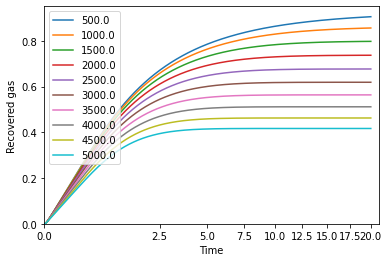

In [36]:
fig, ax = plt.subplots()
for Pf in rf.keys():
    ax.plot(time, rf[Pf], label=str(Pf))
ax.legend()
ax.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))


In [54]:
fluid_properties

,T,P,Z-Factor,Bg,Density,Cg,Viscosity,pseudopressure
10,400,100,0.996798,0.037628,0.234810,0.008746,0.016341,7.937460e+05
11,400,110,0.996530,0.034601,0.255351,0.008046,0.016343,9.407256e+05
12,400,120,0.996264,0.032024,0.275903,0.007451,0.016344,1.100014e+06
13,400,130,0.995999,0.029803,0.296465,0.006937,0.016346,1.271613e+06
14,400,140,0.995737,0.027869,0.317037,0.006491,0.016347,1.455528e+06
...,...,...,...,...,...,...,...,...
1196,400,11960,1.502527,0.000543,16.263662,0.000040,0.029418,4.900670e+09
1197,400,11970,1.503177,0.000543,16.270207,0.000040,0.029430,4.906088e+09
1198,400,11980,1.503827,0.000543,16.276745,0.000040,0.029441,4.911506e+09
1199,400,11990,1.504476,0.000543,16.283278,0.000040,0.029452,4.916925e+09


Reservoir density is 16.2898040359229  and bottom density is 2.11203367322722
Reservoir density is 16.2898040359229  and bottom density is 2.63680578183981
Reservoir density is 16.2898040359229  and bottom density is 3.15916562268714
Reservoir density is 16.2898040359229  and bottom density is 3.67710448991346
Reservoir density is 16.2898040359229  and bottom density is 4.18875425405911


[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Recovered gas'),
 (0.0, 0.06459956729242114),
 None,
 (0.0, 21.000000000000004)]

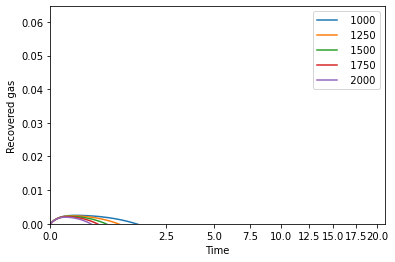

In [55]:
from scipy import interpolate
fluid_properties = (
    pvt_gas[pvt_gas.P>=100]
    )
density_interp = interpolate.interp1d(fluid_properties["P"], fluid_properties["Density"])

fig = plt.figure(figsize=(6,4))
ax = plt.axes()
for key in rf.keys():
    print("Reservoir density is",density_interp(Pi)," and bottom density is",density_interp(key))
    ax.plot(time,rf[key]/(density_interp(Pi)-density_interp(key)),label=" {:5.0f}".format(key))
ax.legend()
ax.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))


In [47]:
k=list(rf.keys())[9]
rf[k]/(density_interp(Pi)-density_interp(k))

array([0.00000000e+00, 7.08141032e-06, 2.82985179e-05, ...,
       1.03800299e+00, 1.03800342e+00, 1.03800384e+00])

[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Recovery factor'),
 (0.0, 0.9352331895079818),
 None,
 (0.0, 6.299999999999999)]

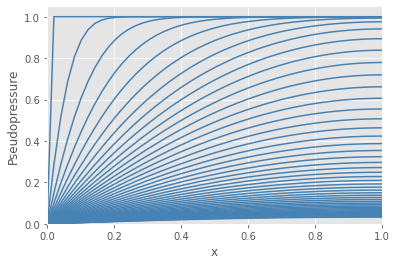

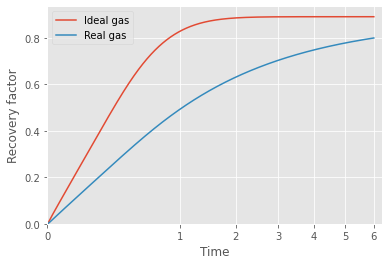

In [8]:
ax = plot_pseudopressure(res_realgas)

fig, ax = plt.subplots()
ax.plot(time, rf_ideal, label="Ideal gas")
ax.plot(time, rf2, label="Real gas")
ax.legend()
ax.set(xlabel="Time", ylabel="Recovery factor", ylim=(0,None), xscale='squareroot', xlim=(0,None))